In [8]:
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import numpy as np
import hdbscan
import socket
import struct

# Konvertierung eines .log files in eine CSV

In [9]:
DS1 = "./csv/convert/capture1_1.csv"
DSMERGED = "./csv/convert/capture_merge_1.csv"
LOG = "./csv/convert/conn.log.labeled"
# turn this to true, to skip all unnecessary fields
FAST = True

In [10]:
df_ds1 = pd.read_csv(DS1)
df_ds1 = df_ds1.drop(['Unnamed: 0'], axis=1)
df_dsmerged = pd.read_csv(DSMERGED)
df_dsmerged = df_dsmerged.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1)

## Split in Training, Validierung und Trainingsdatensatz, Oversampling

In [11]:
from sklearn.preprocessing import StandardScaler
# used to sample the data in a way, that the dataset is equally distributed between categories
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, precision_score, recall_score
from sklearn.model_selection import GridSearchCV

In [12]:
def split(df):
    # train sind 60%, valid und test sind jeweils 20%
    train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])
    return train, valid, test

In [13]:
def scale(df: pd.DataFrame, oversample = False):
    X = df.drop(['label'], axis=1)
    y = df['label']

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    if oversample:
        ros = RandomOverSampler()
        X, y = ros.fit_resample(X, y)

    data = np.hstack((X, np.reshape(y, (-1, 1))))
    return data, X, y

In [14]:
train, valid, test = split(df_ds1)
train, X_train, y_train = scale(train, True) 
valid, X_valid, y_valid = scale(valid, False) 
test, X_test, y_test = scale(test, False) 

### aNN

In [15]:
import tensorflow as tf

In [16]:
def plot_nn(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
    ax1.plot(history.history['loss'], label='loss')
    ax1.plot(history.history['val_loss'], label='val_loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Binary Crossentropy')
    ax1.legend()
    ax1.grid(True)
    ax2.plot(history.history['accuracy'], label='accuracy')
    ax2.plot(history.history['val_accuracy'], label='val_accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    plt.show()

In [17]:
def nn_train(X_train: pd.DataFrame, y_train: pd.DataFrame, X_valid: pd.DataFrame, y_valid: pd.DataFrame, epochs: int, nodes: int, dropout_prob: float, lr: int, batch_size: int):
    """Train a neural network

    Args:
        Y_train (pd.DataFrame): [the training data X]
        y_train (pd.DataFrame): [the training data y]
        X_valid, y_valid (pd.DataFrame): [validation data for the model, instead of doing learning rate for validation_split with 0.2]
        epochs (int): [the epochs, how many times the model goes through its training processs]
        nodes (int): how many nodes are created in each dense layer
        dropout_prob (float): [the probability of the dropout layer]
        lr (int): [the learning rate of the optimizer]
        batch_size (int): [the batch size]
    """    
    assert epochs < 1000, "Epochs too big"
    assert nodes <= 128, "Nodes too big"
    assert 0 <= dropout_prob < 1, "Dropout Prob must be probability"
    nn_model = tf.keras.Sequential([
        tf.keras.layers.Dense(nodes, activation='relu', input_shape=(5,)),
        # take certain nodes at a specific rate, and dont train them
        tf.keras.layers.Dropout(dropout_prob),
        tf.keras.layers.Dense(nodes, activation='relu'),
        tf.keras.layers.Dropout(dropout_prob),
        # this will set the output to 0 or 1, which helps with the classification
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    nn_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='binary_crossentropy', metrics=['accuracy'])
    history = nn_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid), verbose=0)
    return nn_model, history


16 nodes, dropout_prob 0, lr 0.1, batch size 32


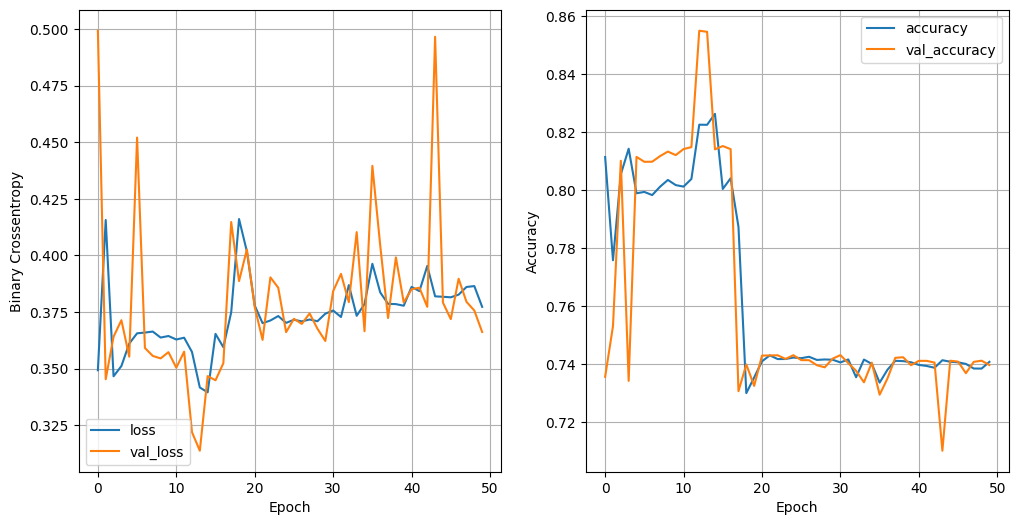

13271/13271 [==============================] - 11s 813us/step - loss: 0.3668 - accuracy: 0.7394
16 nodes, dropout_prob 0, lr 0.1, batch size 64


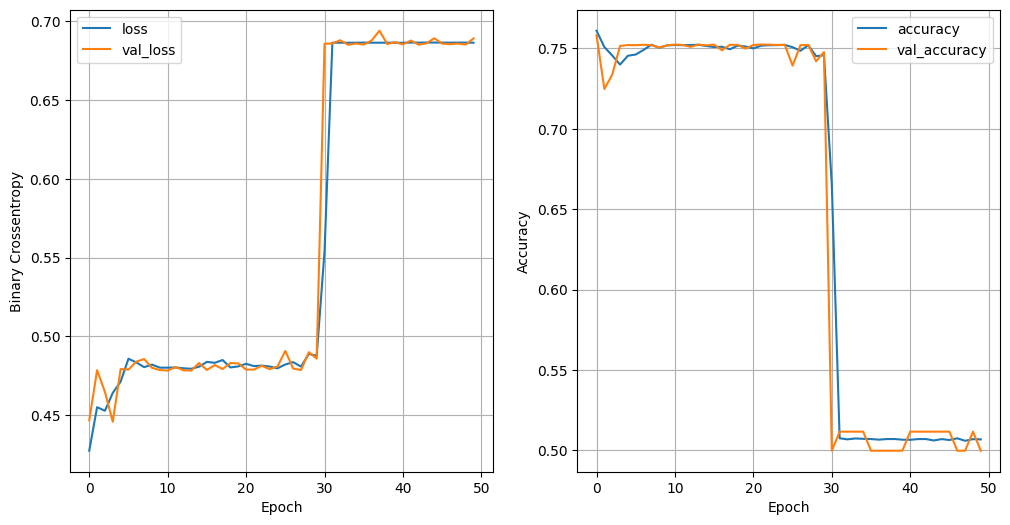

13271/13271 [==============================] - 10s 757us/step - loss: 0.6888 - accuracy: 0.5004
16 nodes, dropout_prob 0, lr 0.1, batch size 128


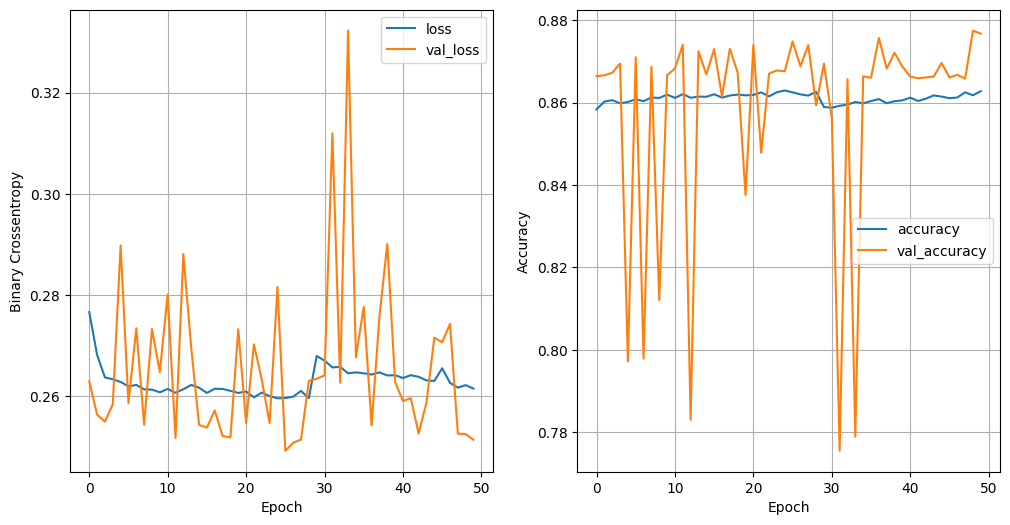

13271/13271 [==============================] - 10s 716us/step - loss: 0.2600 - accuracy: 0.8597
16 nodes, dropout_prob 0, lr 0.005, batch size 32


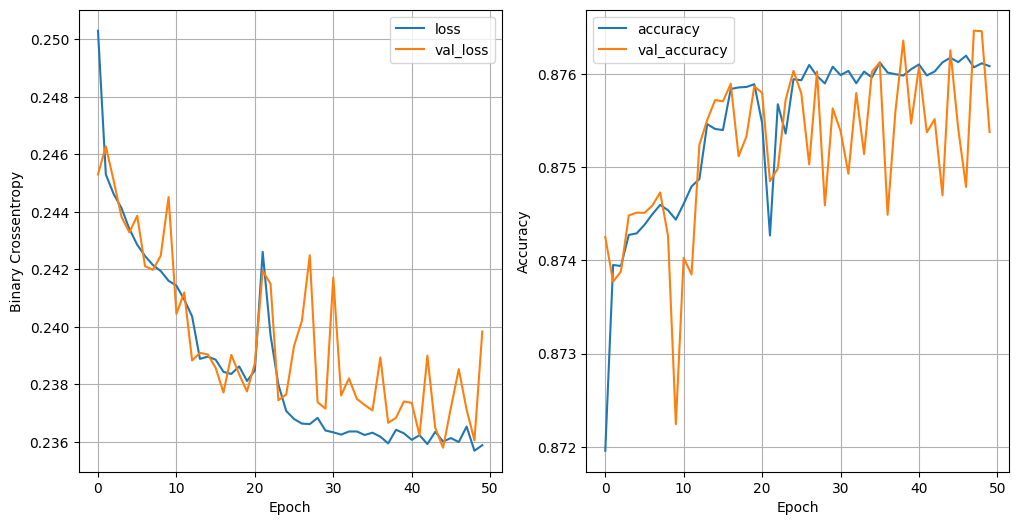

13271/13271 [==============================] - 10s 772us/step - loss: 0.2383 - accuracy: 0.8757
16 nodes, dropout_prob 0, lr 0.005, batch size 64


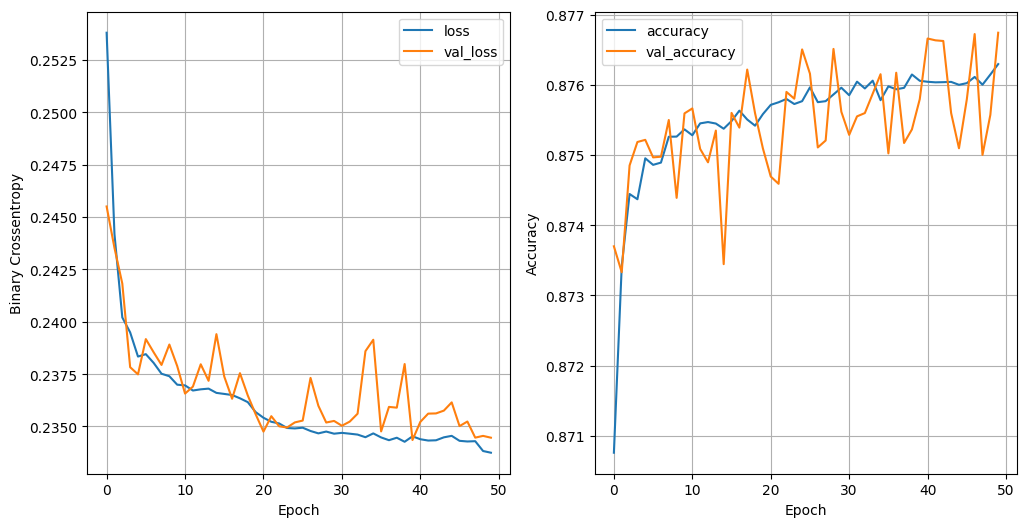

13271/13271 [==============================] - 11s 810us/step - loss: 0.2333 - accuracy: 0.8769
16 nodes, dropout_prob 0, lr 0.005, batch size 128


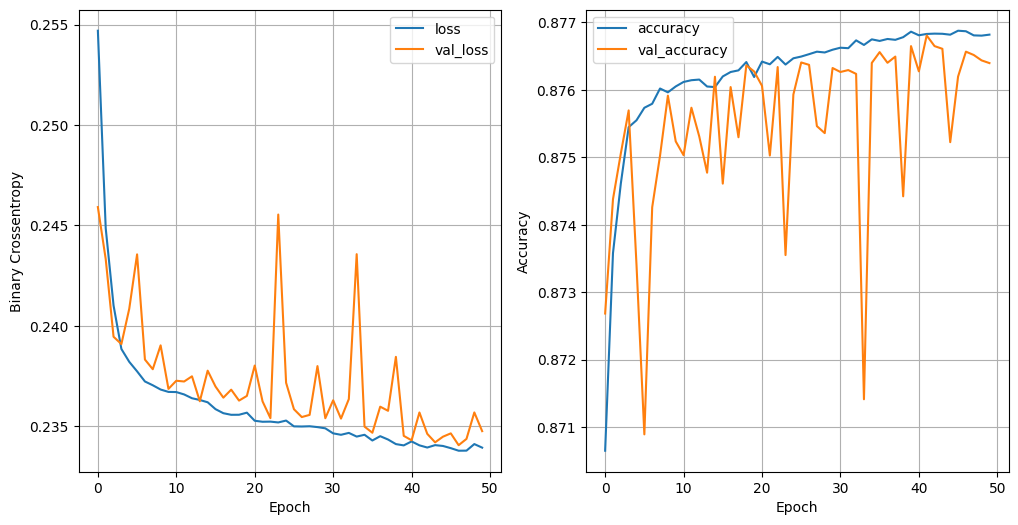

13271/13271 [==============================] - 10s 774us/step - loss: 0.2342 - accuracy: 0.8768
16 nodes, dropout_prob 0, lr 0.001, batch size 32


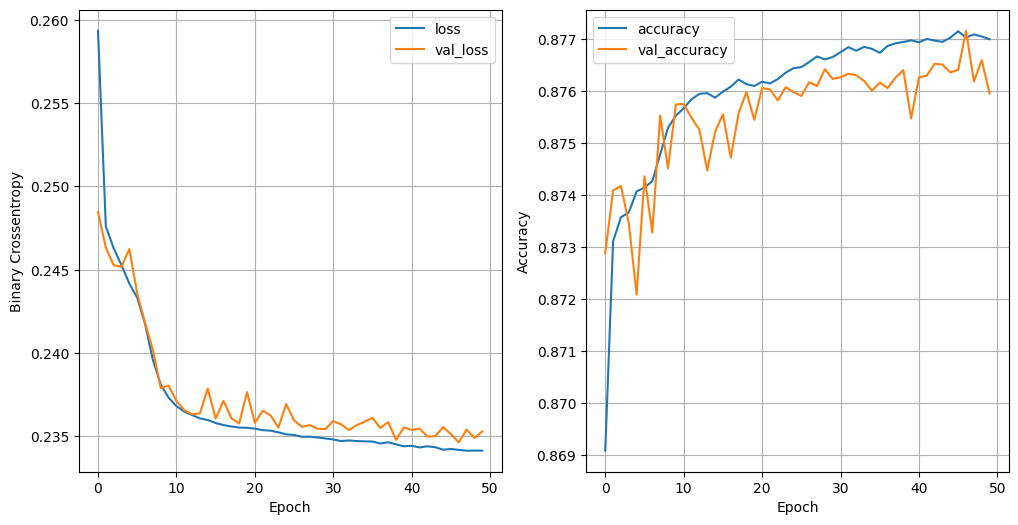

13271/13271 [==============================] - 10s 767us/step - loss: 0.2343 - accuracy: 0.8763
16 nodes, dropout_prob 0, lr 0.001, batch size 64


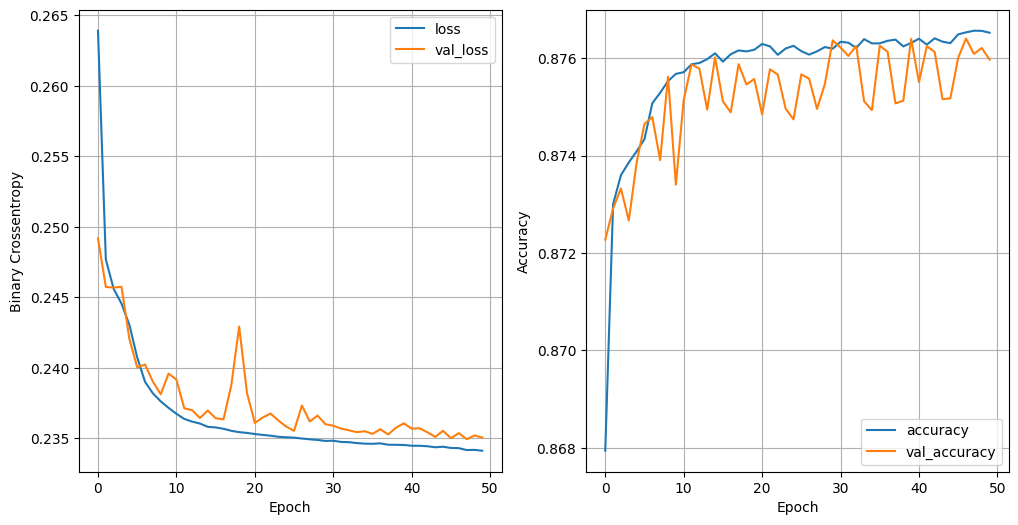

13271/13271 [==============================] - 9s 714us/step - loss: 0.2339 - accuracy: 0.8765
16 nodes, dropout_prob 0, lr 0.001, batch size 128


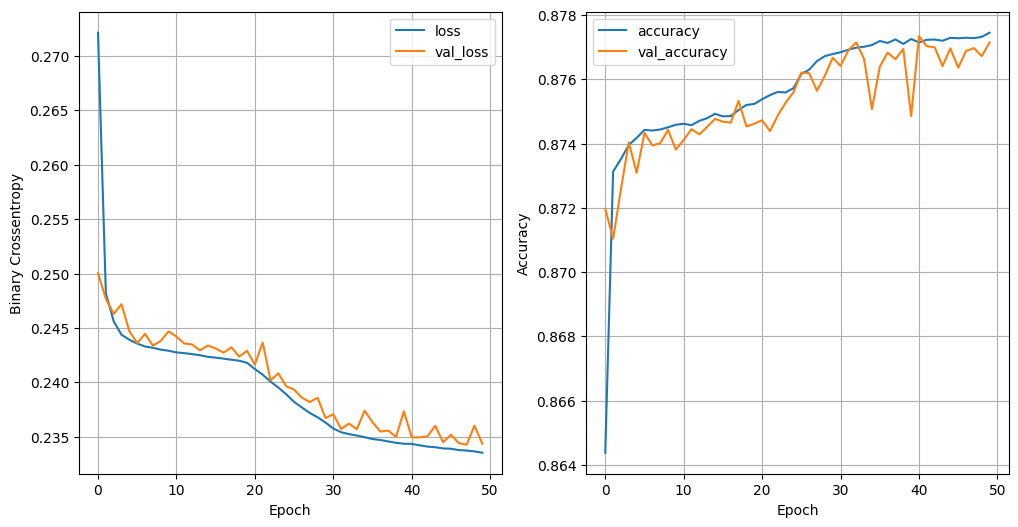

13271/13271 [==============================] - 11s 807us/step - loss: 0.2333 - accuracy: 0.8777
16 nodes, dropout_prob 0.2, lr 0.1, batch size 32


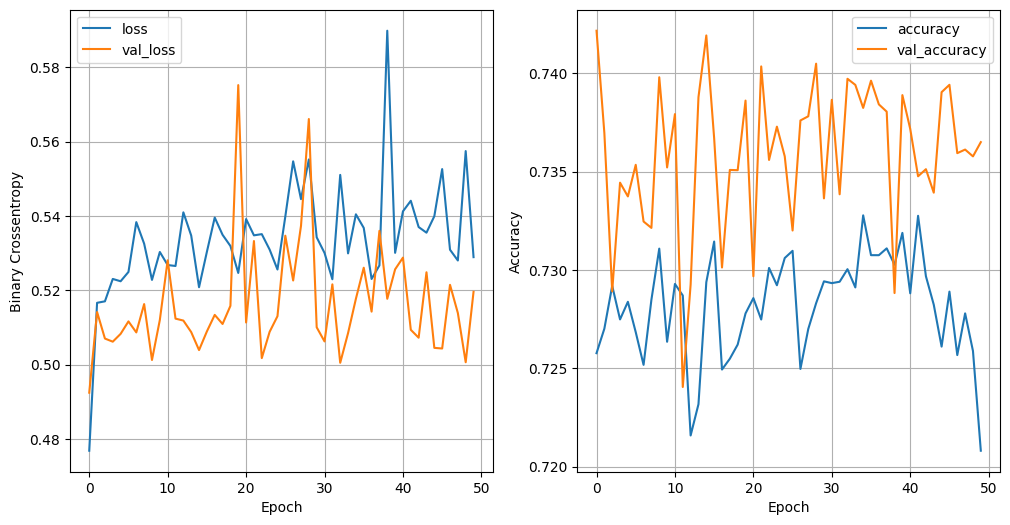

13271/13271 [==============================] - 10s 748us/step - loss: 0.5346 - accuracy: 0.7362
16 nodes, dropout_prob 0.2, lr 0.1, batch size 64


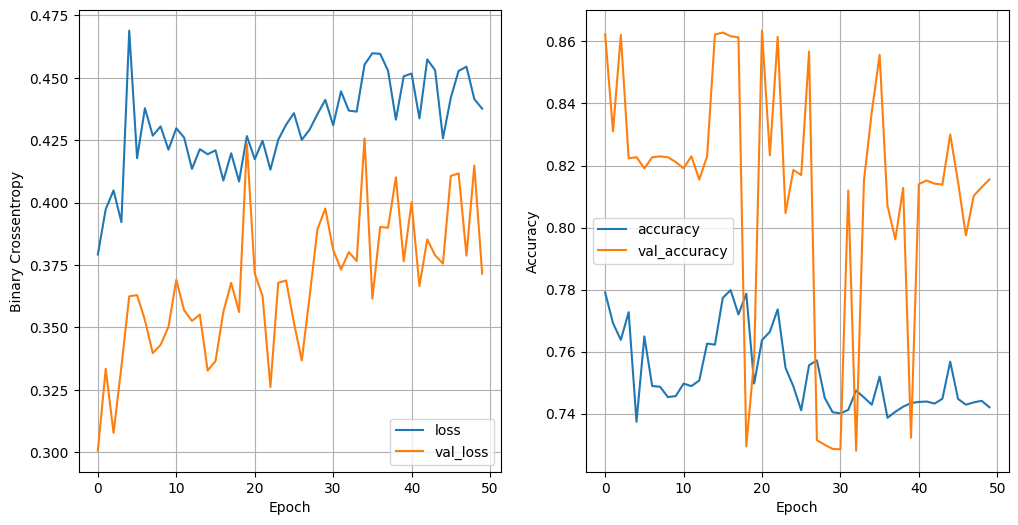

13271/13271 [==============================] - 10s 730us/step - loss: 0.3853 - accuracy: 0.8159
16 nodes, dropout_prob 0.2, lr 0.1, batch size 128


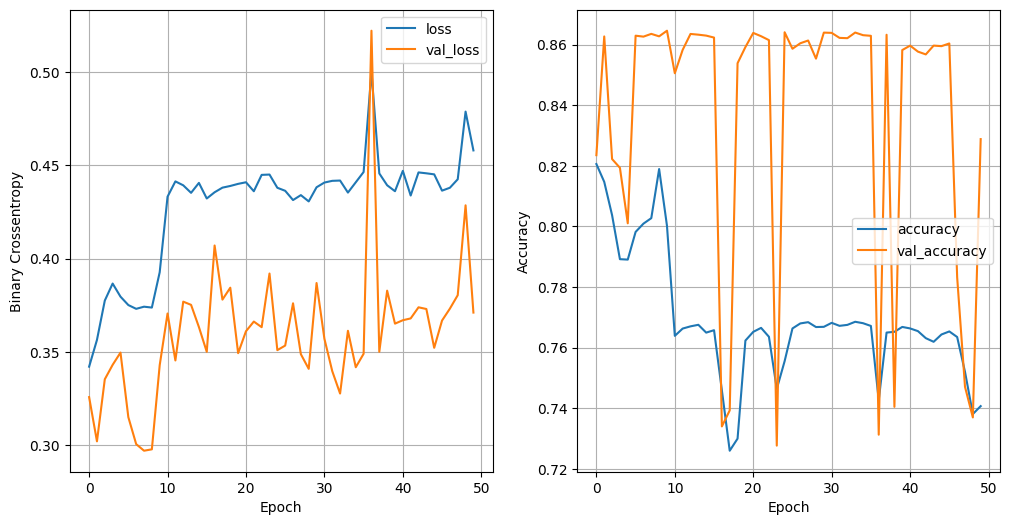

13271/13271 [==============================] - 11s 796us/step - loss: 0.3798 - accuracy: 0.8285
16 nodes, dropout_prob 0.2, lr 0.005, batch size 32


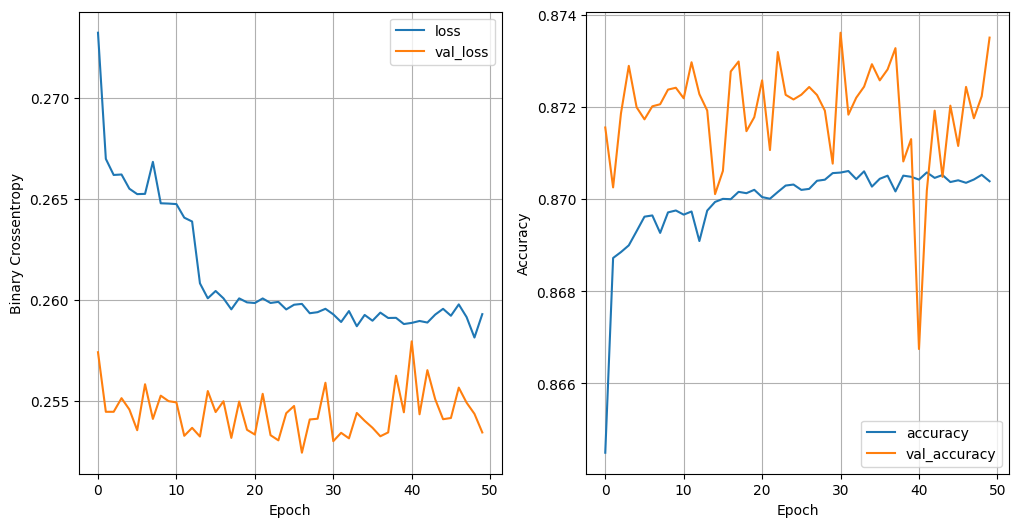

13271/13271 [==============================] - 10s 781us/step - loss: 0.2524 - accuracy: 0.8740
16 nodes, dropout_prob 0.2, lr 0.005, batch size 64


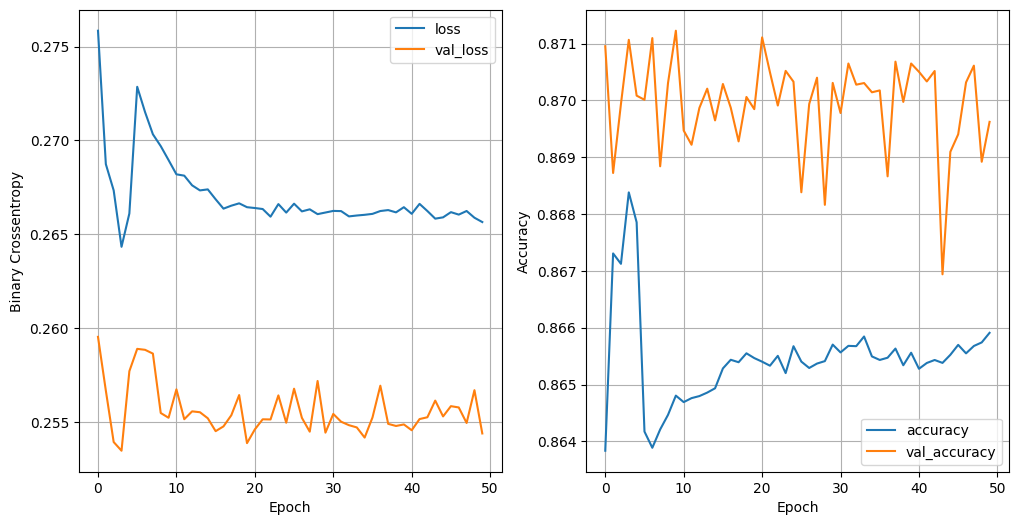

13271/13271 [==============================] - 10s 772us/step - loss: 0.2539 - accuracy: 0.8703
16 nodes, dropout_prob 0.2, lr 0.005, batch size 128


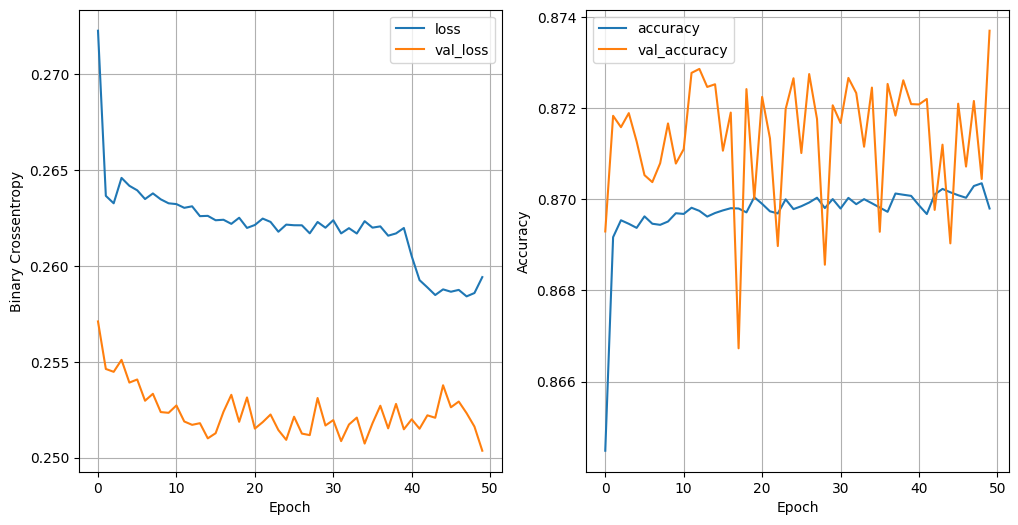

13271/13271 [==============================] - 10s 721us/step - loss: 0.2495 - accuracy: 0.8740
16 nodes, dropout_prob 0.2, lr 0.001, batch size 32


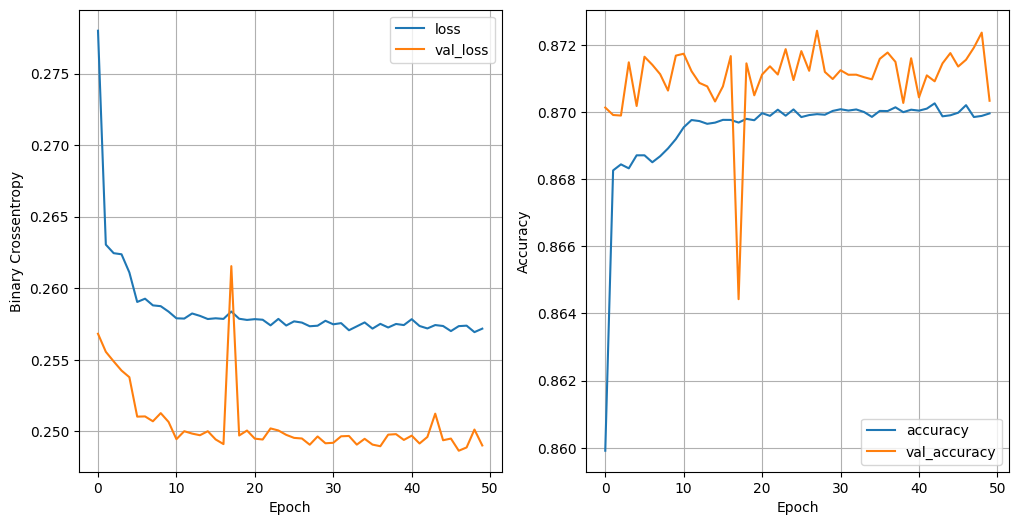

13271/13271 [==============================] - 10s 778us/step - loss: 0.2483 - accuracy: 0.8710
16 nodes, dropout_prob 0.2, lr 0.001, batch size 64


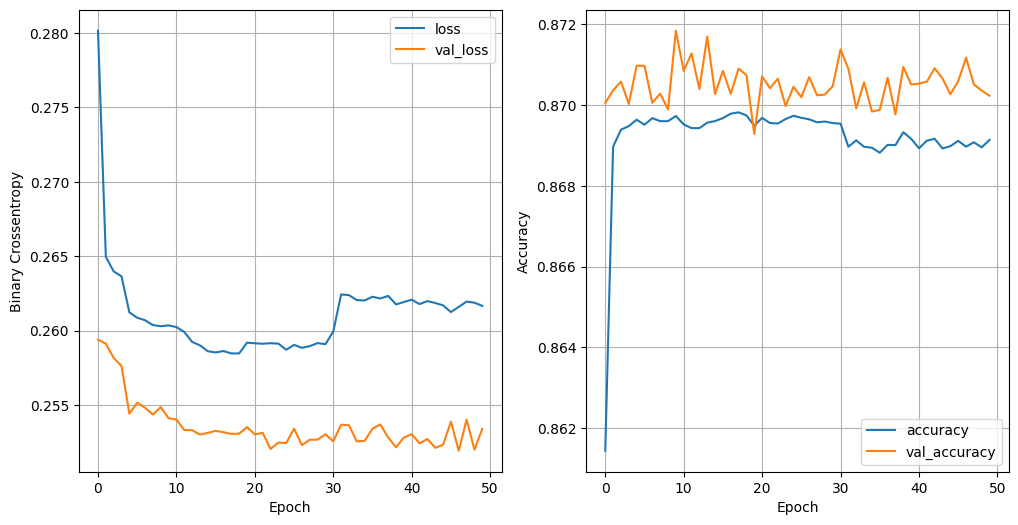

13271/13271 [==============================] - 10s 757us/step - loss: 0.2528 - accuracy: 0.8708
16 nodes, dropout_prob 0.2, lr 0.001, batch size 128


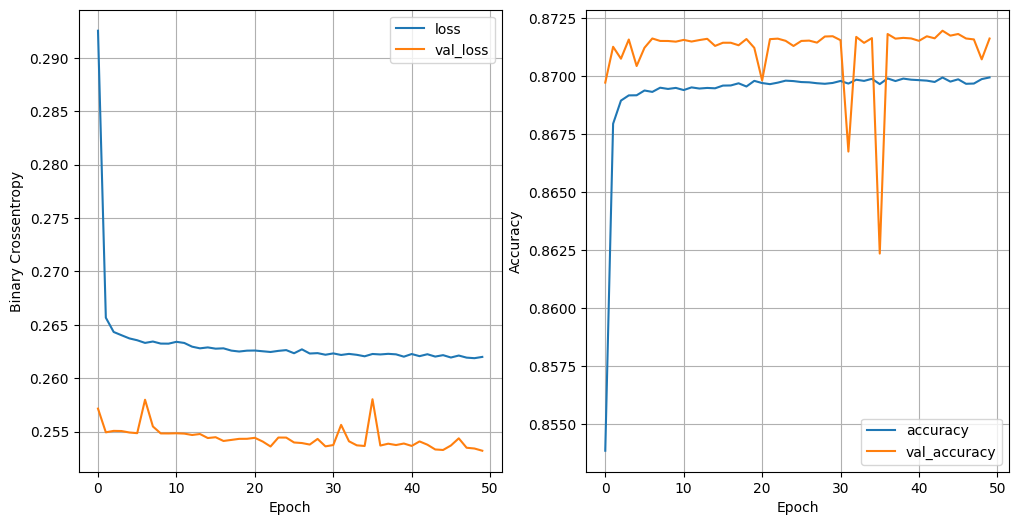

13271/13271 [==============================] - 12s 904us/step - loss: 0.2527 - accuracy: 0.8720
32 nodes, dropout_prob 0, lr 0.1, batch size 32


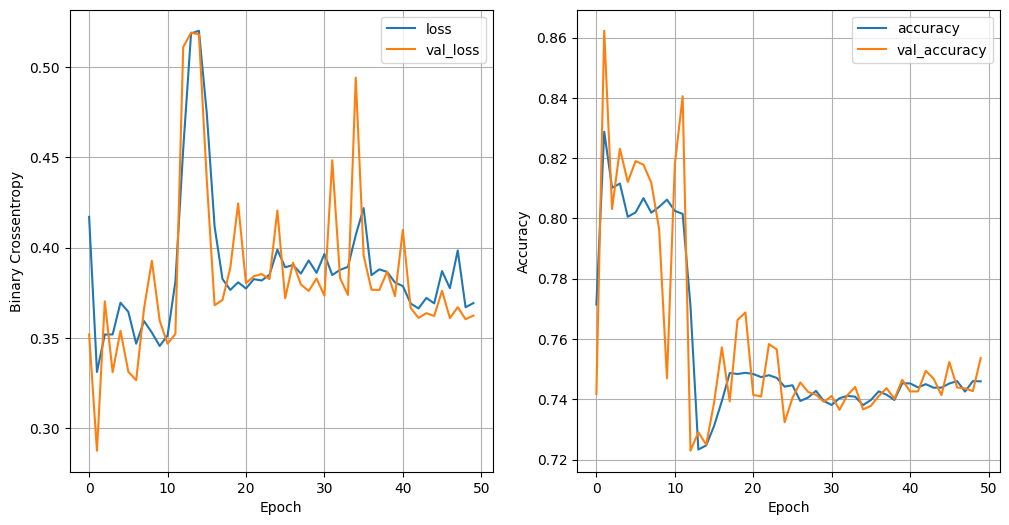

13271/13271 [==============================] - 11s 798us/step - loss: 0.3580 - accuracy: 0.7546
32 nodes, dropout_prob 0, lr 0.1, batch size 64


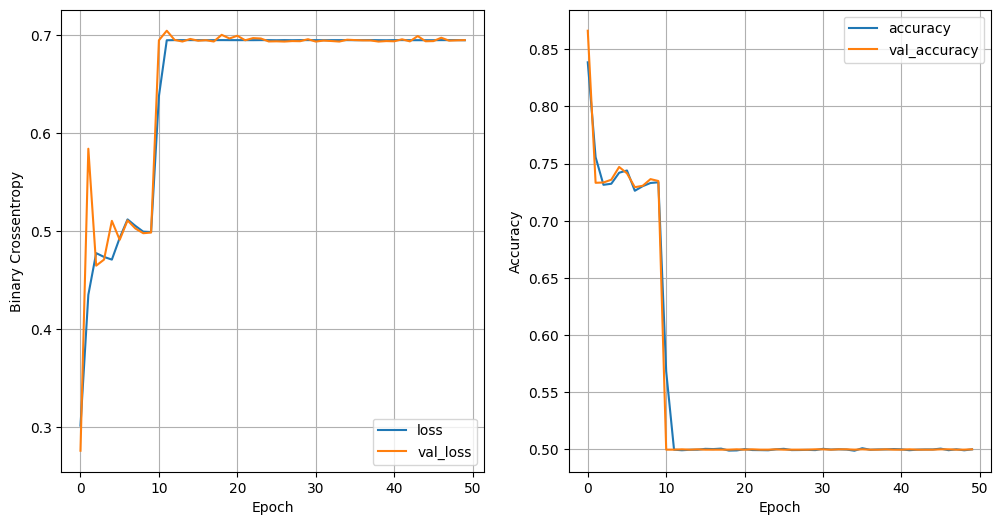

13271/13271 [==============================] - 12s 871us/step - loss: 0.6947 - accuracy: 0.4996
32 nodes, dropout_prob 0, lr 0.1, batch size 128


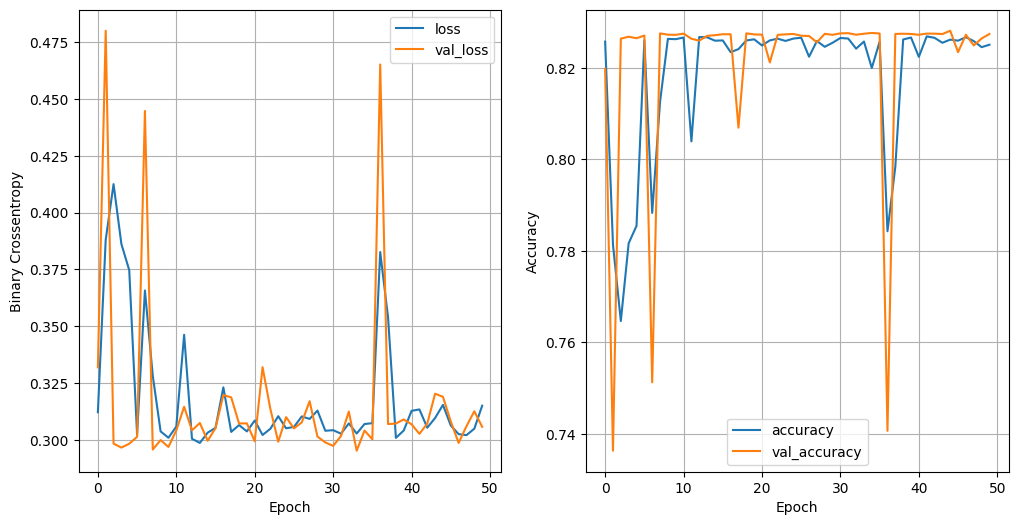

13271/13271 [==============================] - 11s 804us/step - loss: 0.3030 - accuracy: 0.8277
32 nodes, dropout_prob 0, lr 0.005, batch size 32


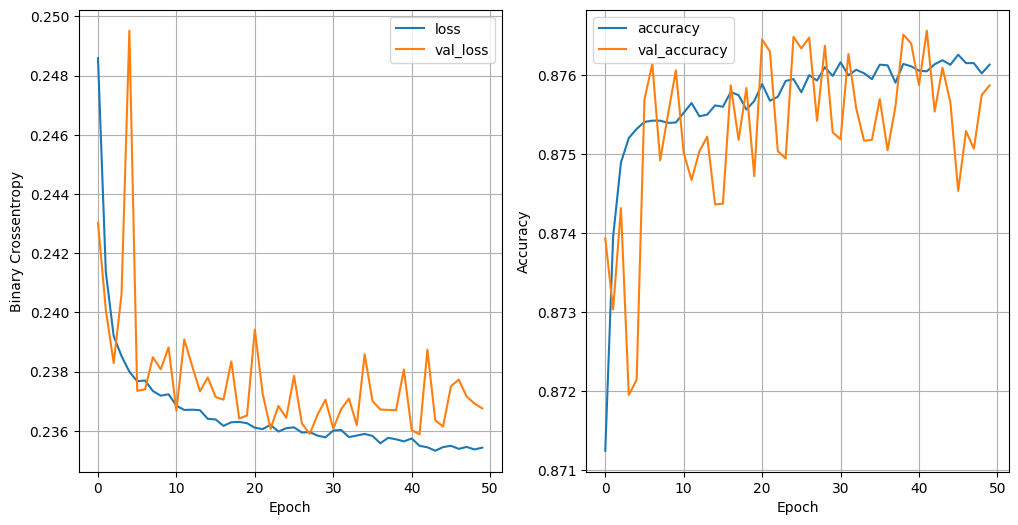

13271/13271 [==============================] - 11s 860us/step - loss: 0.2357 - accuracy: 0.8763
32 nodes, dropout_prob 0, lr 0.005, batch size 64


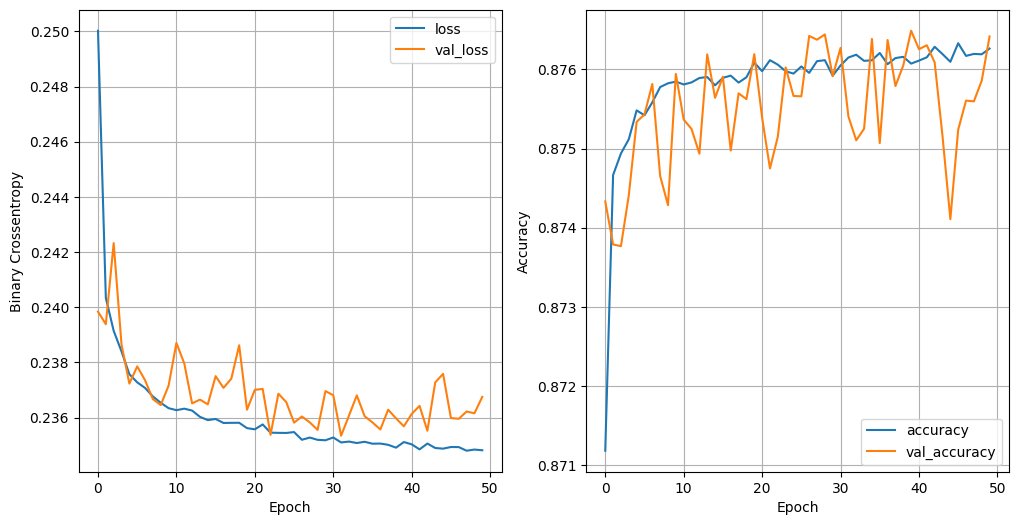

13271/13271 [==============================] - 11s 836us/step - loss: 0.2357 - accuracy: 0.8768
32 nodes, dropout_prob 0, lr 0.005, batch size 128


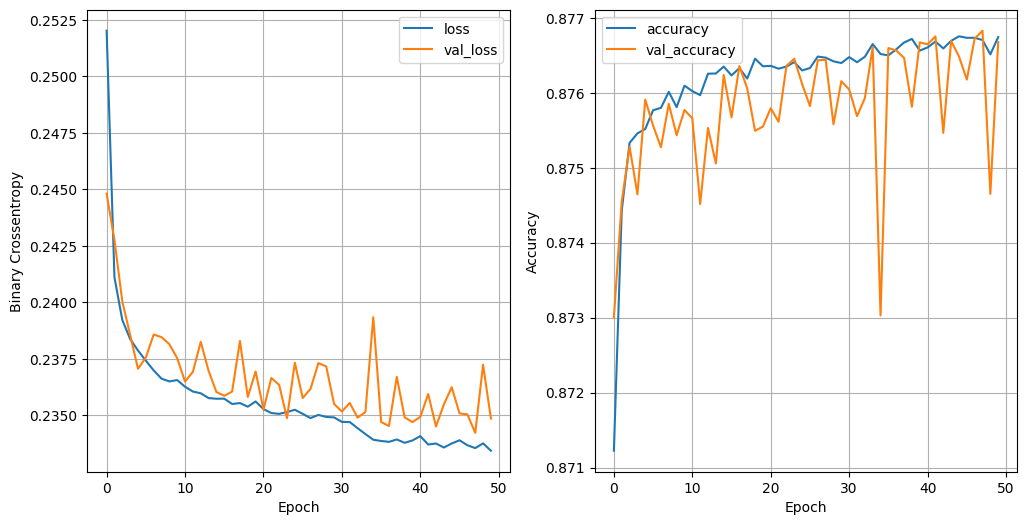

13271/13271 [==============================] - 13s 995us/step - loss: 0.2346 - accuracy: 0.8769
32 nodes, dropout_prob 0, lr 0.001, batch size 32


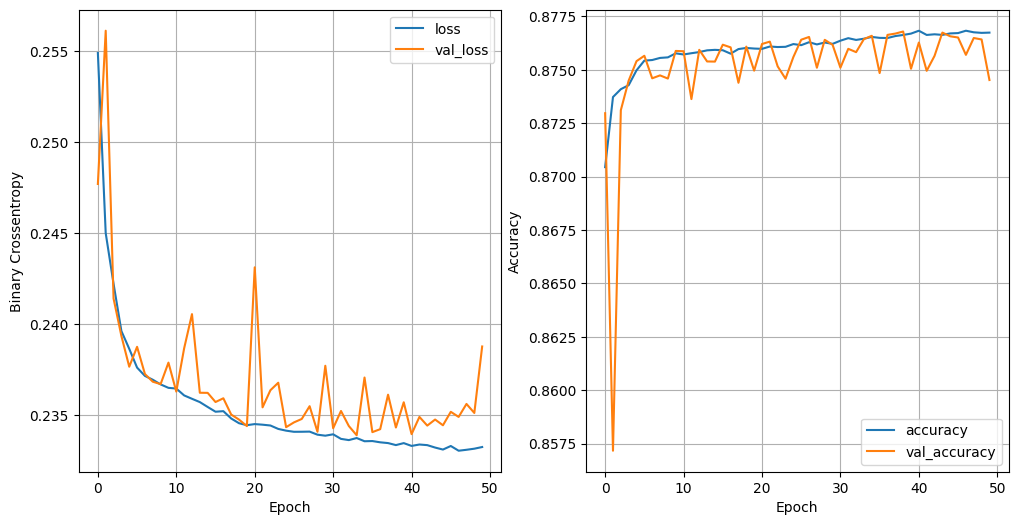

13271/13271 [==============================] - 11s 847us/step - loss: 0.2360 - accuracy: 0.8753
32 nodes, dropout_prob 0, lr 0.001, batch size 64


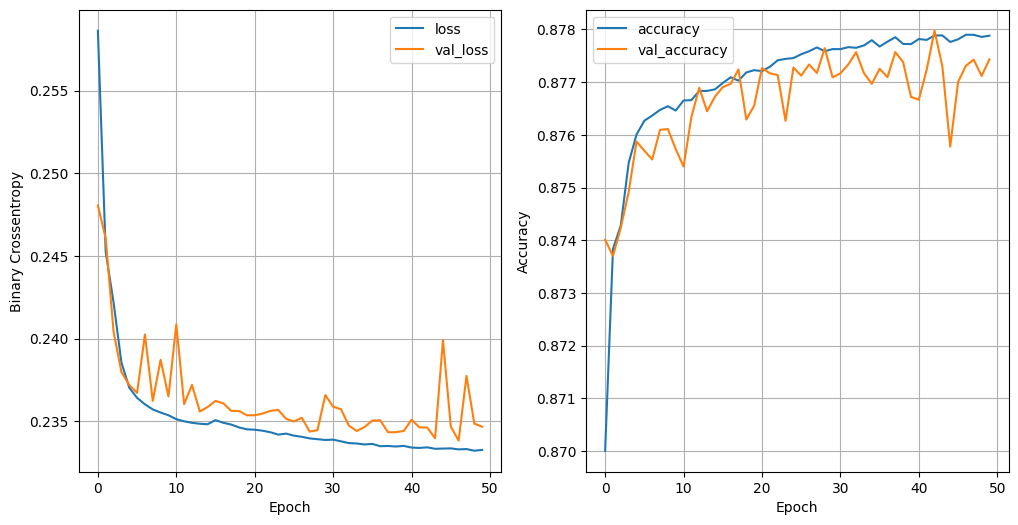

13271/13271 [==============================] - 11s 842us/step - loss: 0.2340 - accuracy: 0.8778
32 nodes, dropout_prob 0, lr 0.001, batch size 128


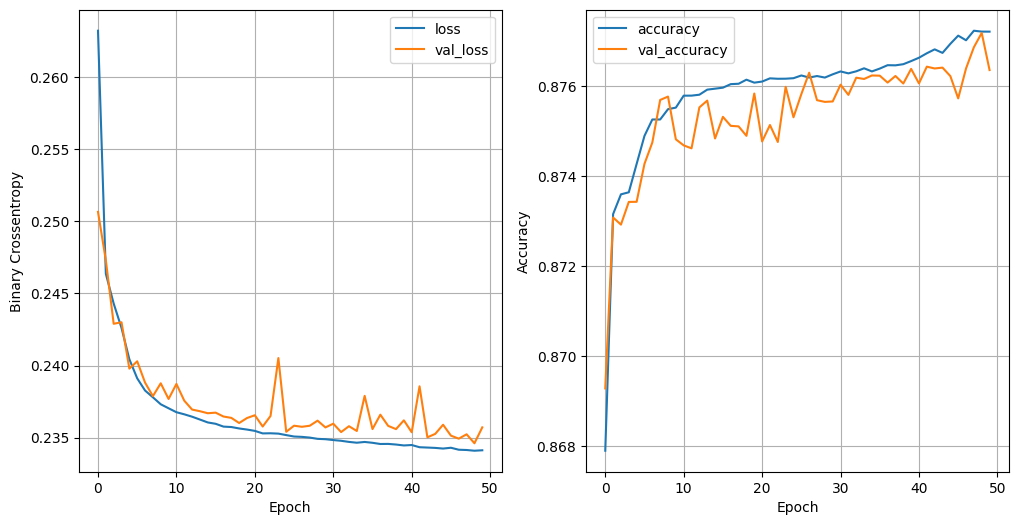

13271/13271 [==============================] - 11s 852us/step - loss: 0.2350 - accuracy: 0.8765
32 nodes, dropout_prob 0.2, lr 0.1, batch size 32


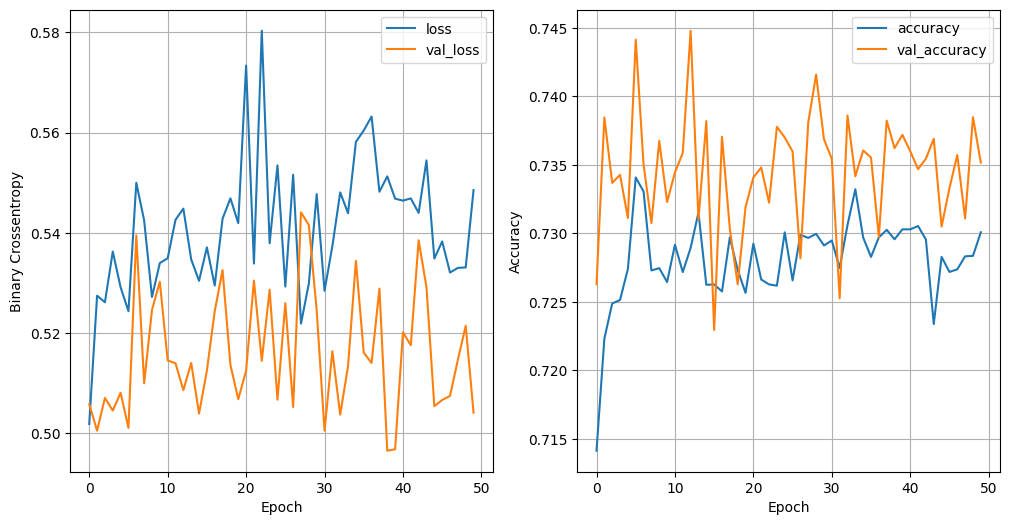

13271/13271 [==============================] - 11s 836us/step - loss: 0.5090 - accuracy: 0.7357
32 nodes, dropout_prob 0.2, lr 0.1, batch size 64


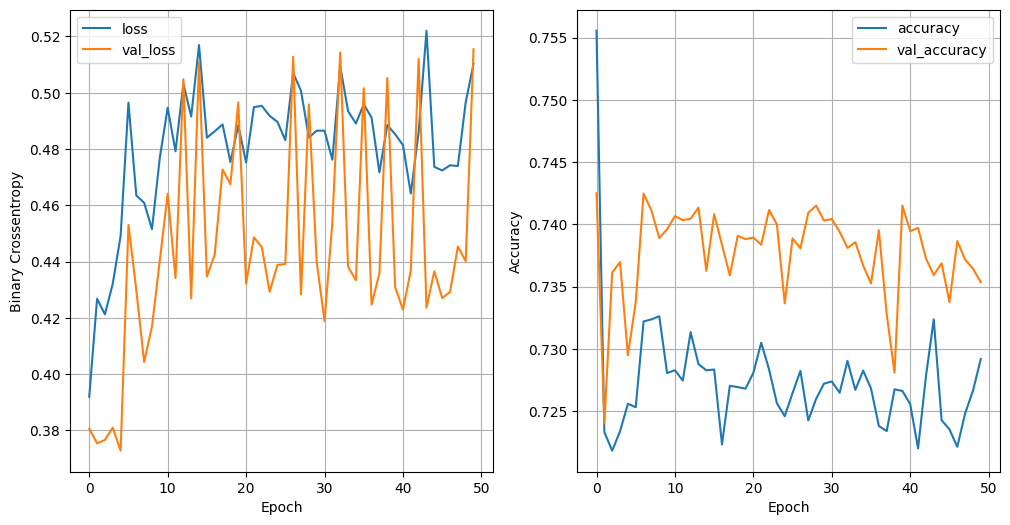

13271/13271 [==============================] - 11s 846us/step - loss: 0.5242 - accuracy: 0.7357
32 nodes, dropout_prob 0.2, lr 0.1, batch size 128


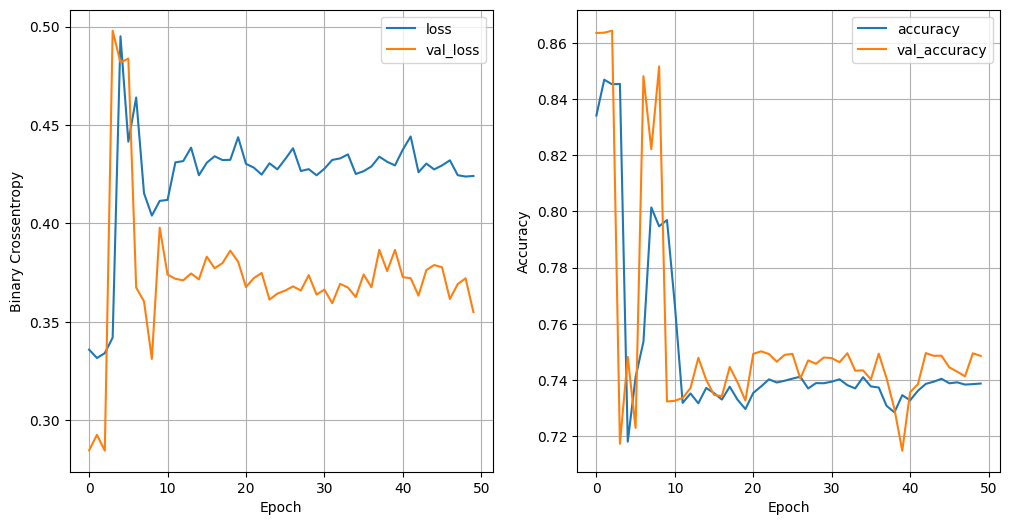

13271/13271 [==============================] - 12s 865us/step - loss: 0.3605 - accuracy: 0.7493
32 nodes, dropout_prob 0.2, lr 0.005, batch size 32


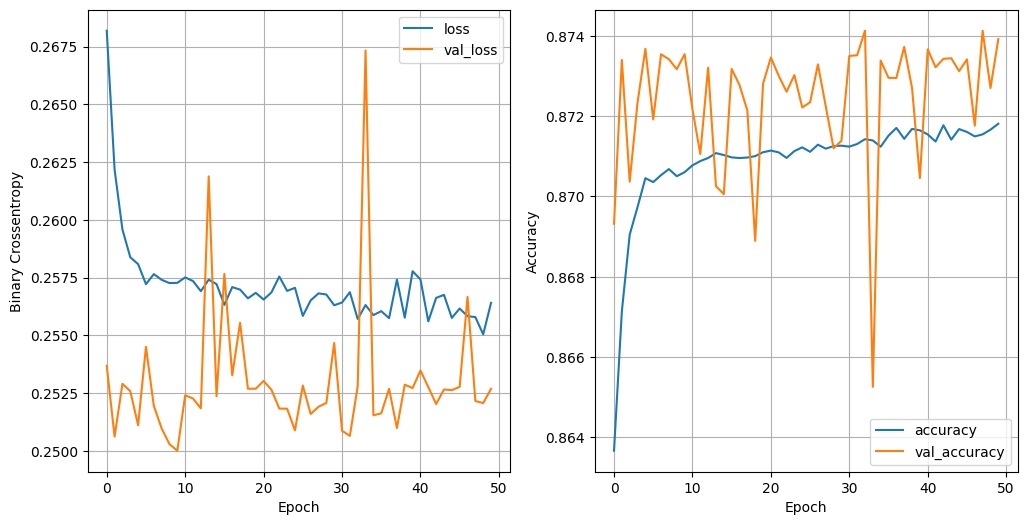

13271/13271 [==============================] - 11s 852us/step - loss: 0.2510 - accuracy: 0.8735
32 nodes, dropout_prob 0.2, lr 0.005, batch size 64


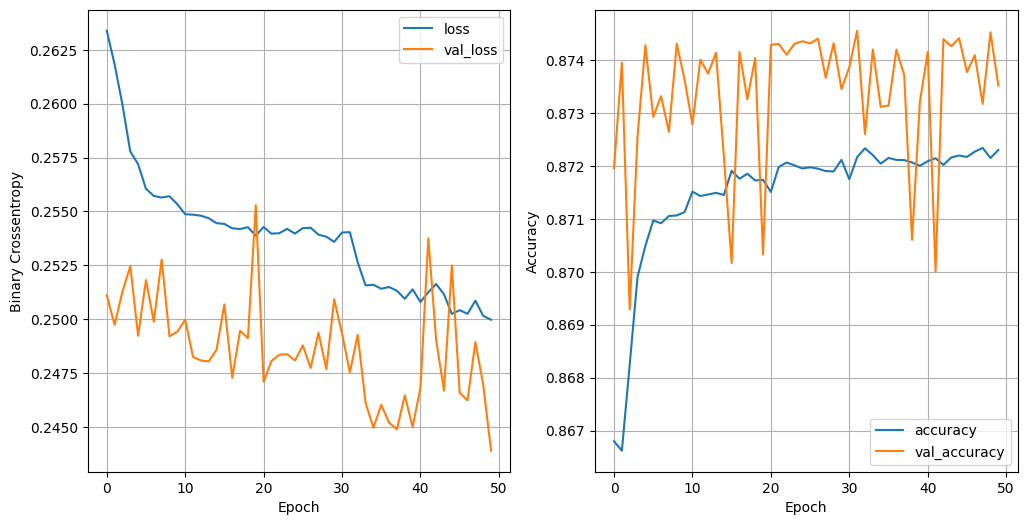

13271/13271 [==============================] - 11s 845us/step - loss: 0.2429 - accuracy: 0.8740
32 nodes, dropout_prob 0.2, lr 0.005, batch size 128


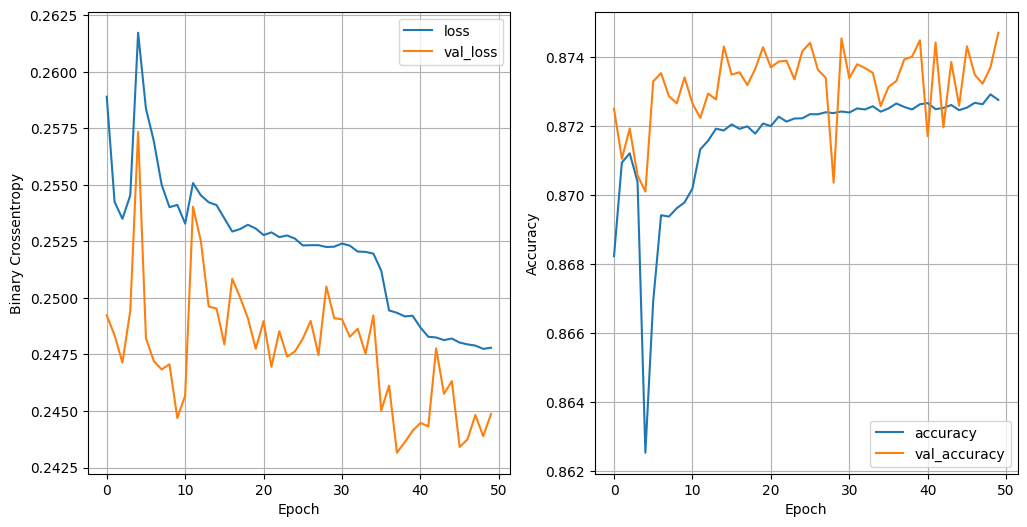

13271/13271 [==============================] - 11s 849us/step - loss: 0.2446 - accuracy: 0.8749
32 nodes, dropout_prob 0.2, lr 0.001, batch size 32


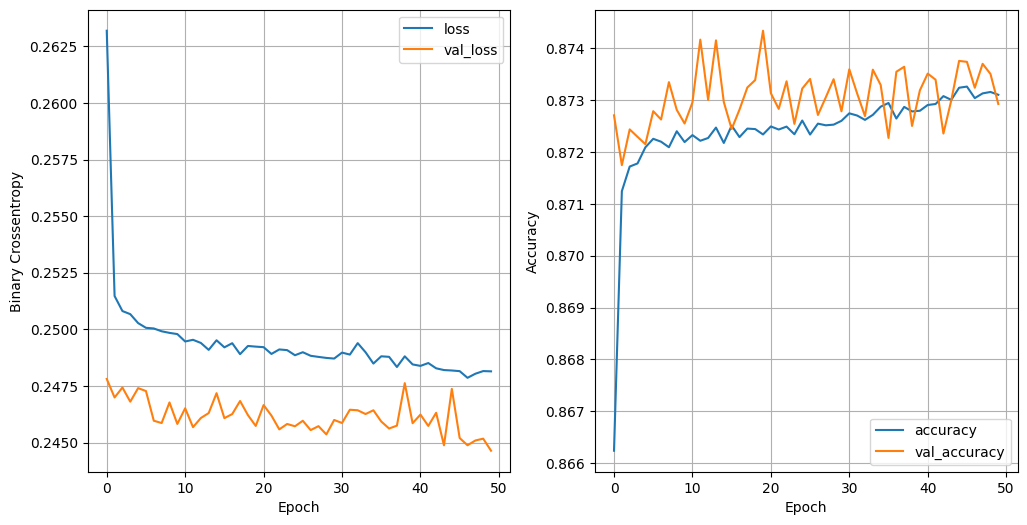

13271/13271 [==============================] - 12s 900us/step - loss: 0.2443 - accuracy: 0.8735
32 nodes, dropout_prob 0.2, lr 0.001, batch size 64


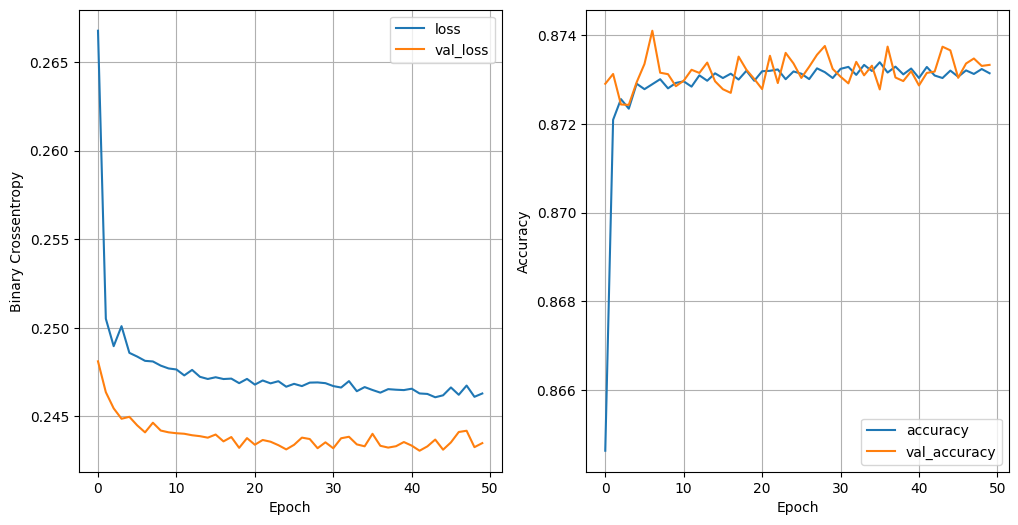

13271/13271 [==============================] - 11s 845us/step - loss: 0.2429 - accuracy: 0.8737
32 nodes, dropout_prob 0.2, lr 0.001, batch size 128


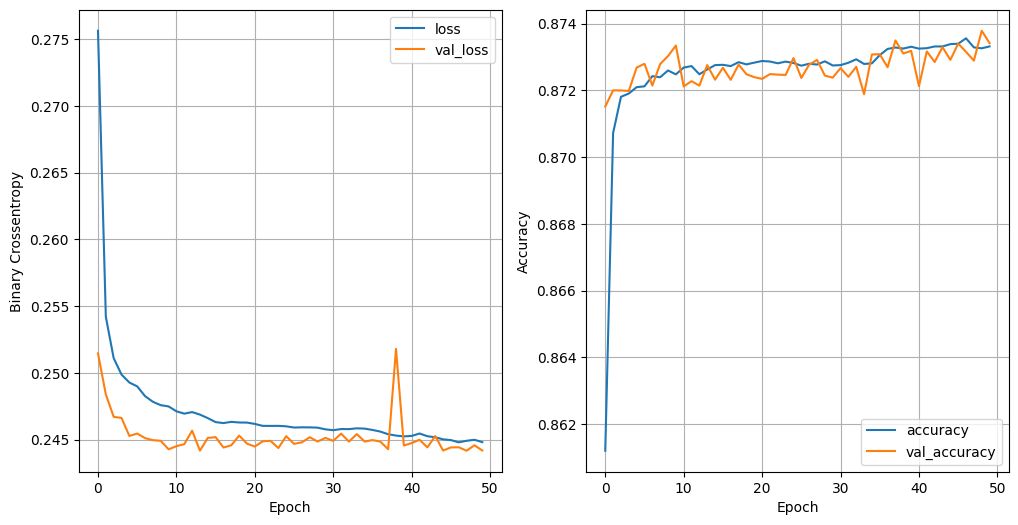

13271/13271 [==============================] - 10s 720us/step - loss: 0.2433 - accuracy: 0.8739
64 nodes, dropout_prob 0, lr 0.1, batch size 32


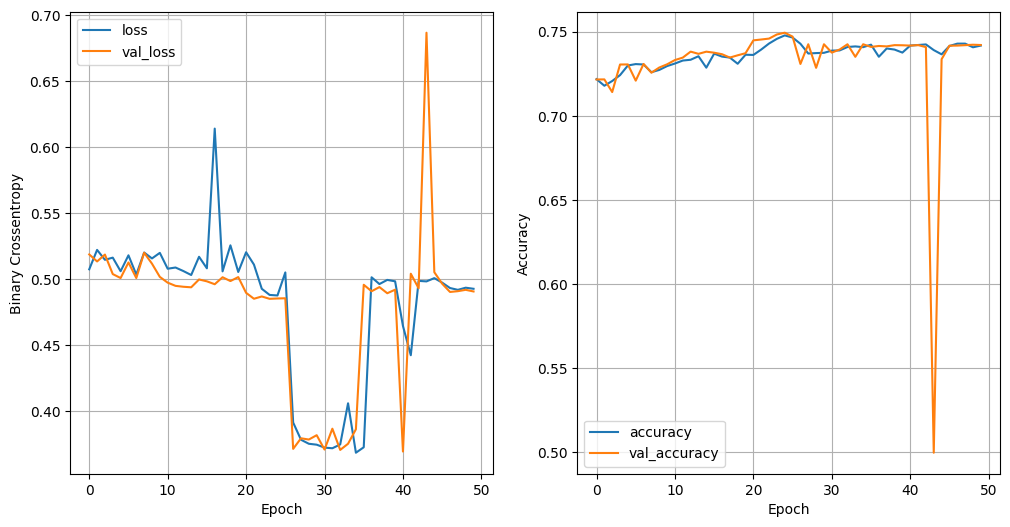

13271/13271 [==============================] - 13s 958us/step - loss: 0.4903 - accuracy: 0.7421
64 nodes, dropout_prob 0, lr 0.1, batch size 64


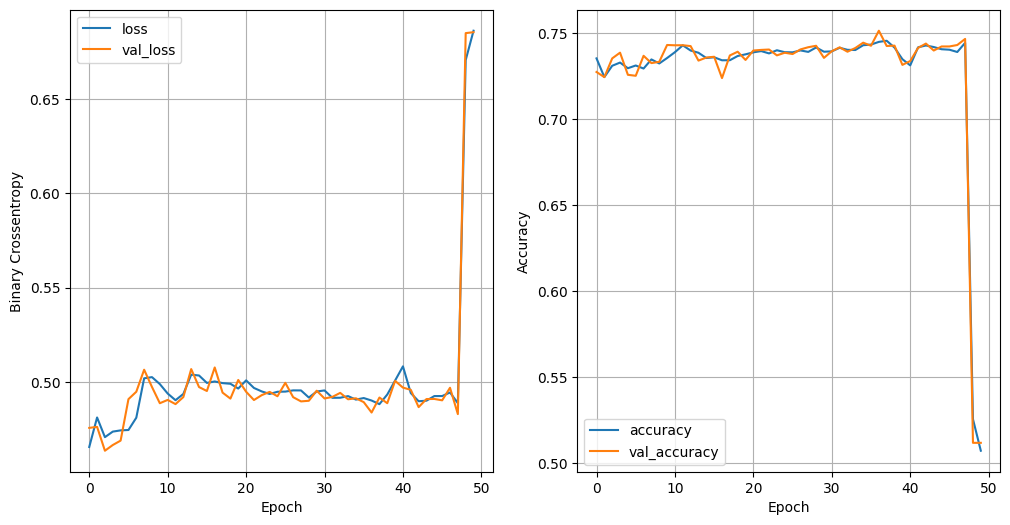

13271/13271 [==============================] - 11s 852us/step - loss: 0.6854 - accuracy: 0.5115
64 nodes, dropout_prob 0, lr 0.1, batch size 128


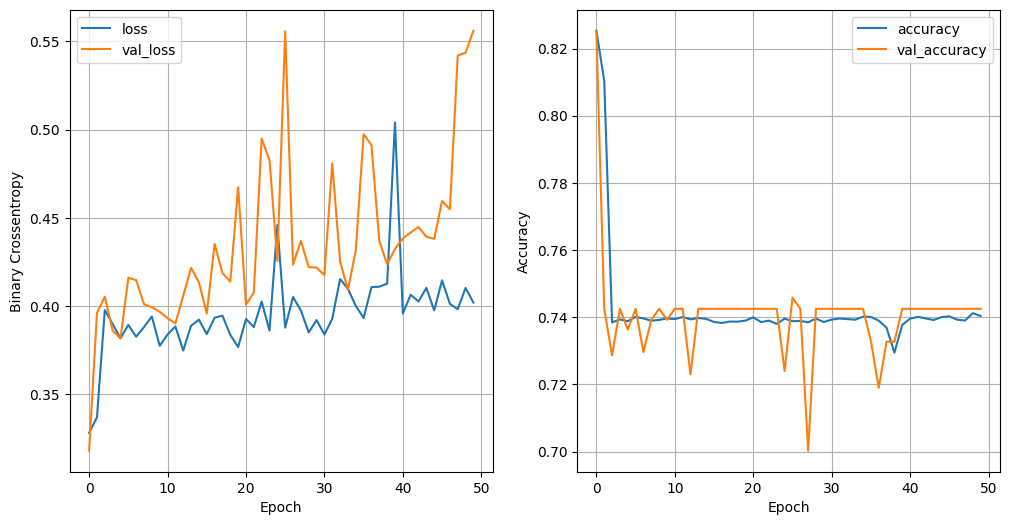

13271/13271 [==============================] - 11s 834us/step - loss: 0.4951 - accuracy: 0.7427
64 nodes, dropout_prob 0, lr 0.005, batch size 32


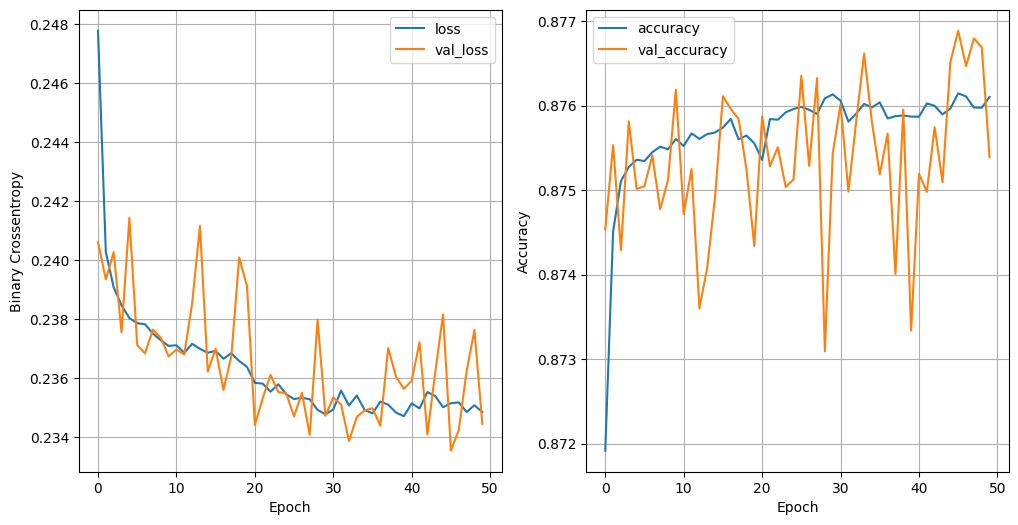

13271/13271 [==============================] - 12s 916us/step - loss: 0.2331 - accuracy: 0.8761
64 nodes, dropout_prob 0, lr 0.005, batch size 64


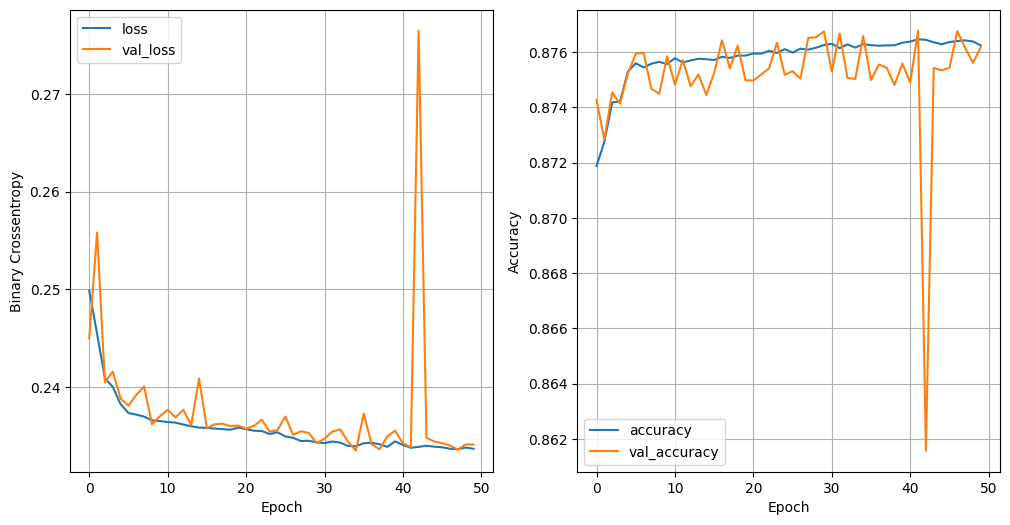

13271/13271 [==============================] - 12s 895us/step - loss: 0.2333 - accuracy: 0.8759
64 nodes, dropout_prob 0, lr 0.005, batch size 128


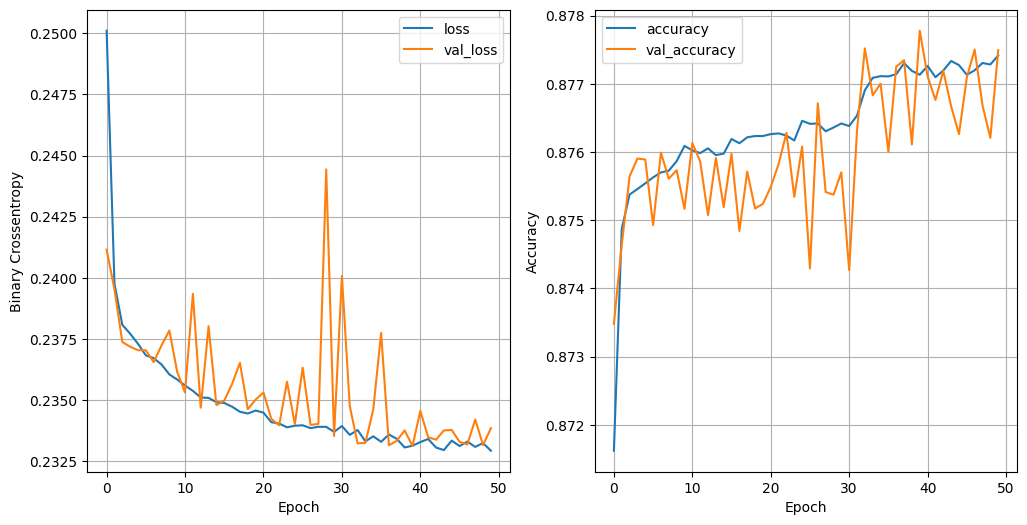

13271/13271 [==============================] - 12s 880us/step - loss: 0.2335 - accuracy: 0.8775
64 nodes, dropout_prob 0, lr 0.001, batch size 32


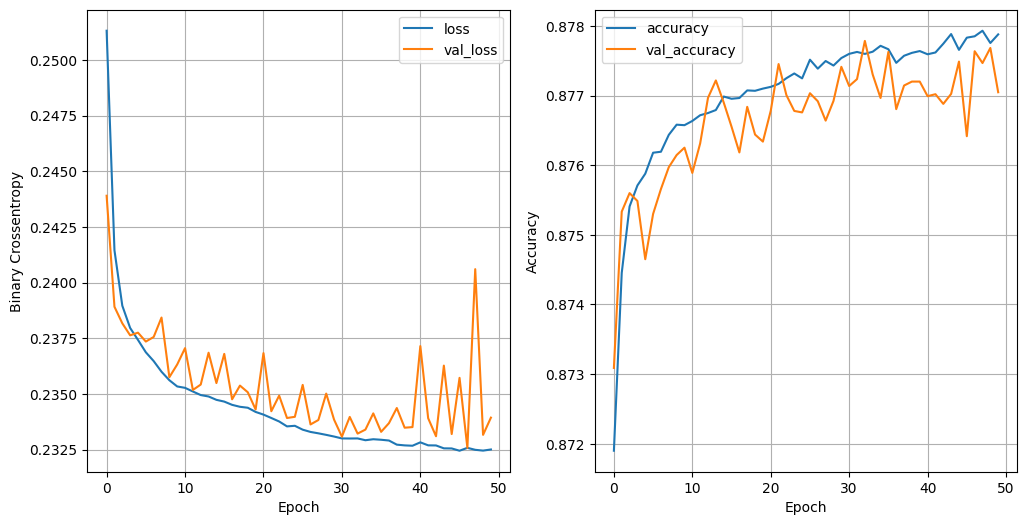

13271/13271 [==============================] - 10s 729us/step - loss: 0.2341 - accuracy: 0.8776
64 nodes, dropout_prob 0, lr 0.001, batch size 64


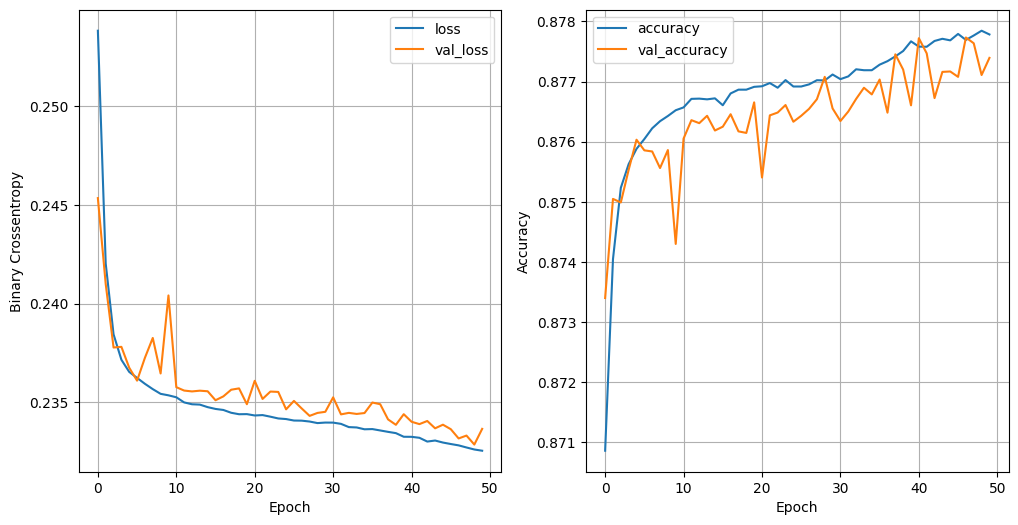

13271/13271 [==============================] - 13s 1ms/step - loss: 0.2326 - accuracy: 0.8779
64 nodes, dropout_prob 0, lr 0.001, batch size 128


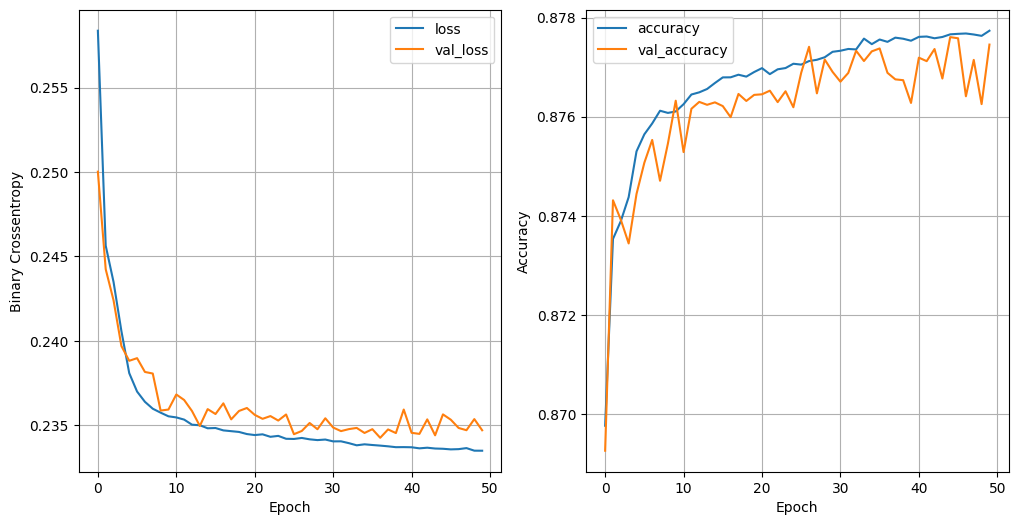

13271/13271 [==============================] - 13s 990us/step - loss: 0.2338 - accuracy: 0.8778
64 nodes, dropout_prob 0.2, lr 0.1, batch size 32


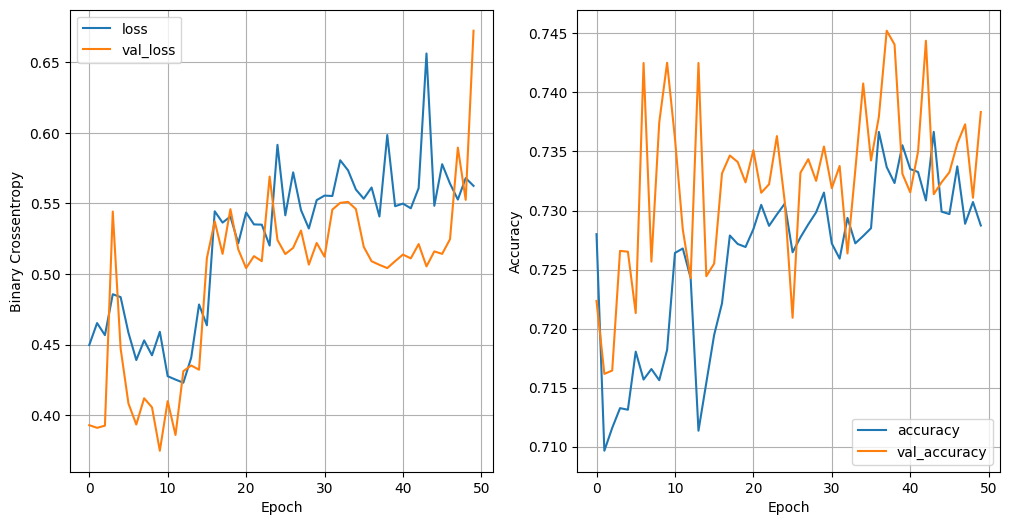

13271/13271 [==============================] - 13s 1ms/step - loss: 0.6794 - accuracy: 0.7388
64 nodes, dropout_prob 0.2, lr 0.1, batch size 64


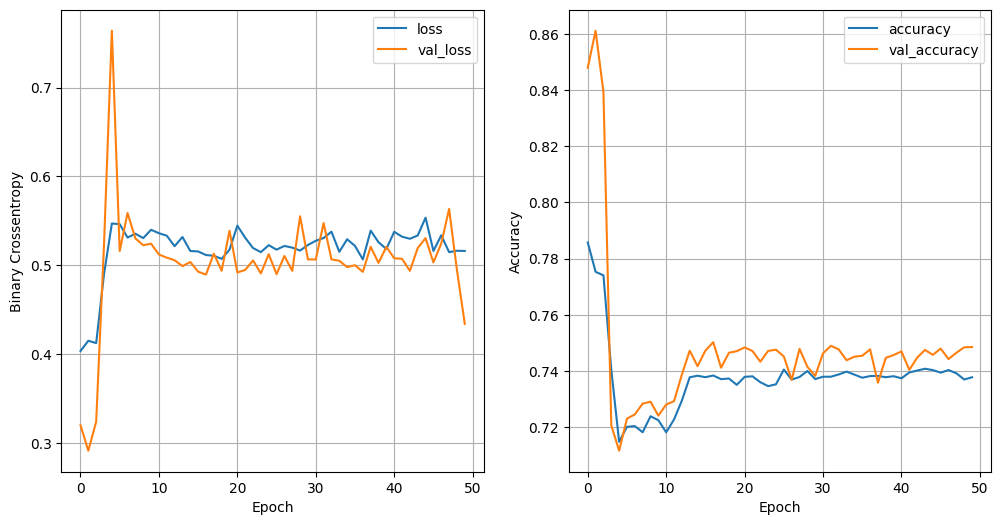

13271/13271 [==============================] - 12s 931us/step - loss: 0.4401 - accuracy: 0.7494
64 nodes, dropout_prob 0.2, lr 0.1, batch size 128


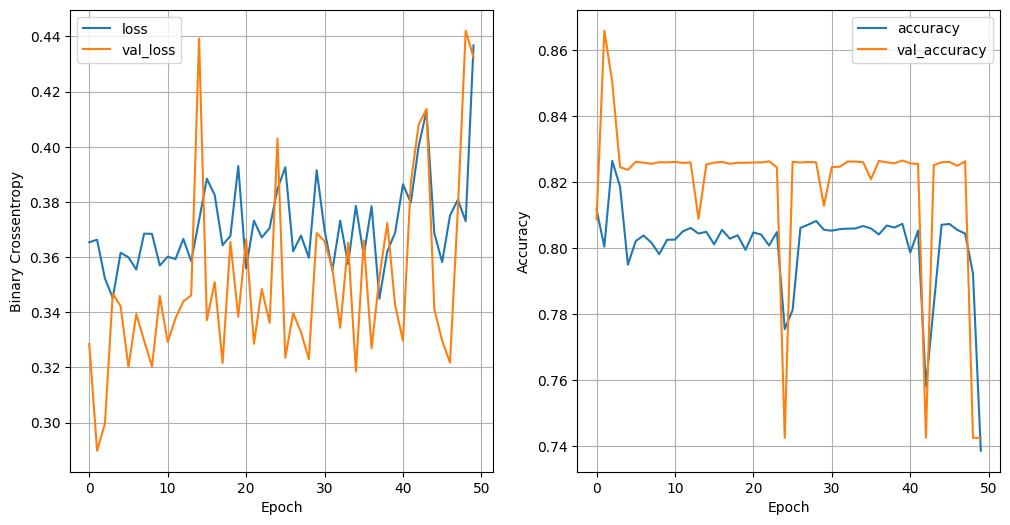

13271/13271 [==============================] - 11s 839us/step - loss: 0.3983 - accuracy: 0.7427
64 nodes, dropout_prob 0.2, lr 0.005, batch size 32


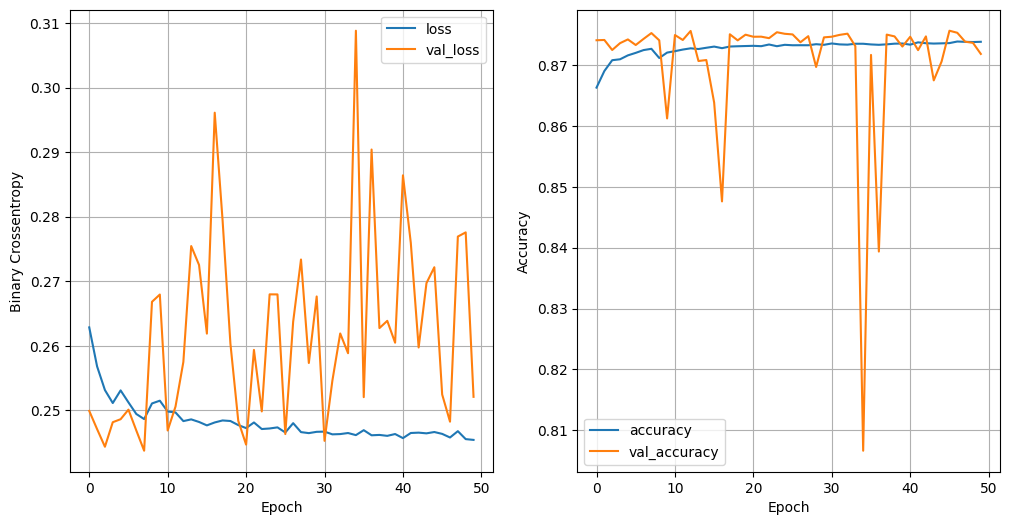

13271/13271 [==============================] - 12s 936us/step - loss: 0.2531 - accuracy: 0.8722
64 nodes, dropout_prob 0.2, lr 0.005, batch size 64


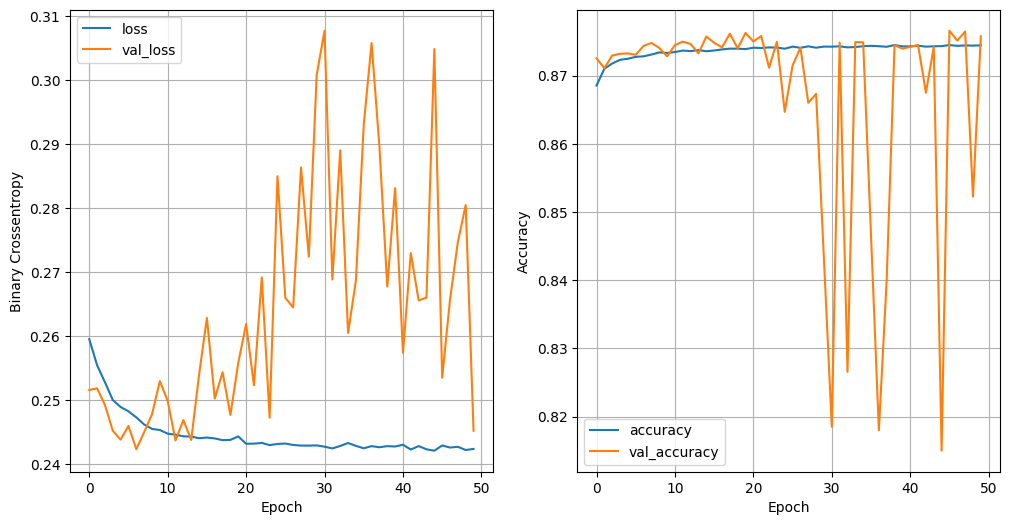

13271/13271 [==============================] - 13s 977us/step - loss: 0.2444 - accuracy: 0.8759
64 nodes, dropout_prob 0.2, lr 0.005, batch size 128


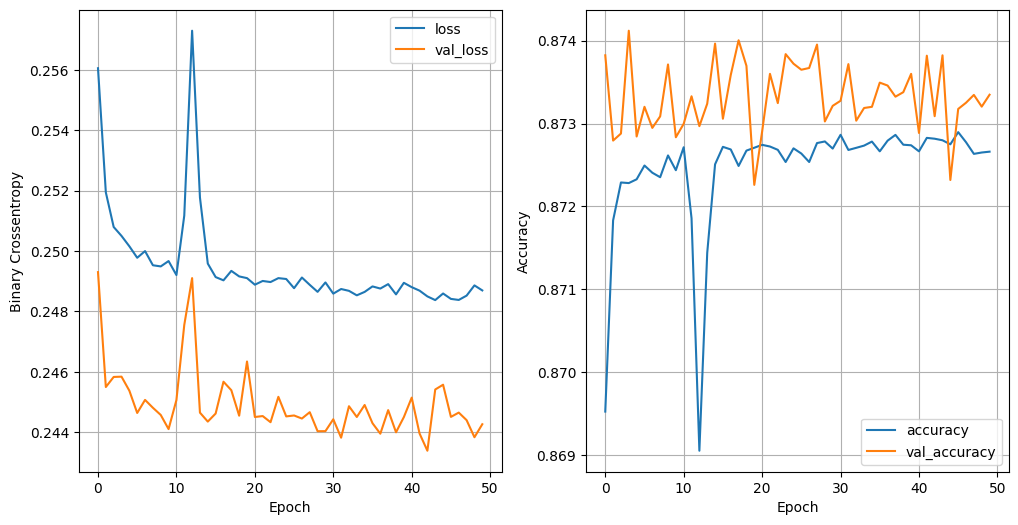

13271/13271 [==============================] - 11s 841us/step - loss: 0.2433 - accuracy: 0.8739
64 nodes, dropout_prob 0.2, lr 0.001, batch size 32


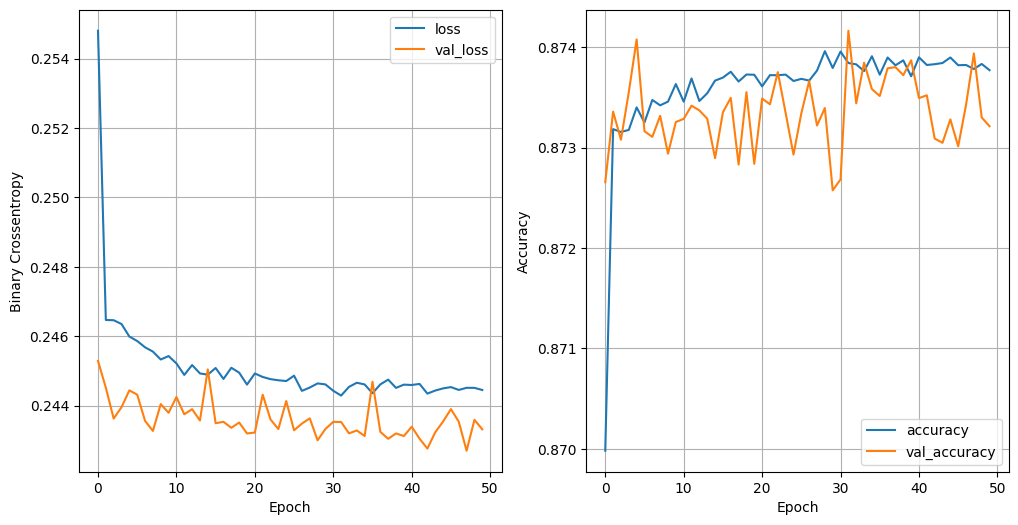

13271/13271 [==============================] - 12s 936us/step - loss: 0.2431 - accuracy: 0.8738
64 nodes, dropout_prob 0.2, lr 0.001, batch size 64


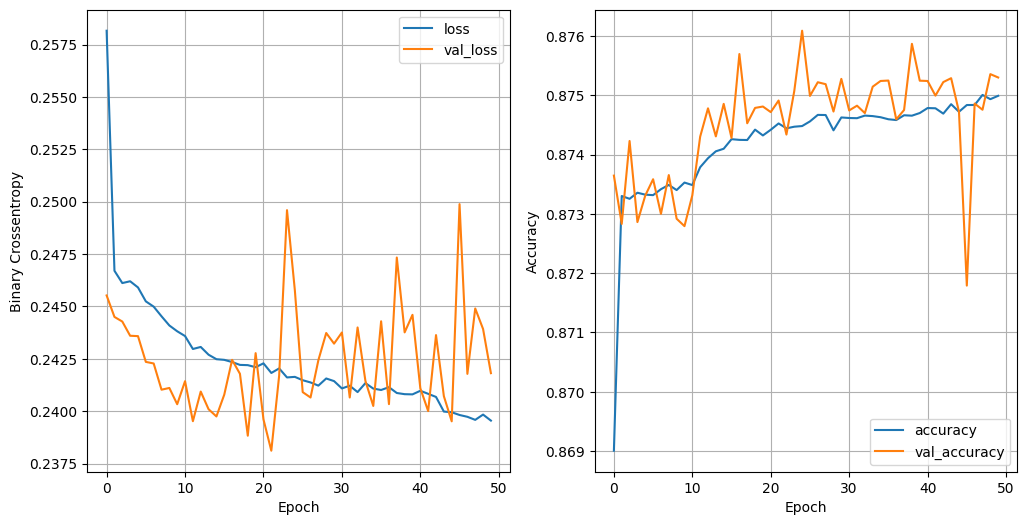

13271/13271 [==============================] - 12s 921us/step - loss: 0.2411 - accuracy: 0.8759
64 nodes, dropout_prob 0.2, lr 0.001, batch size 128


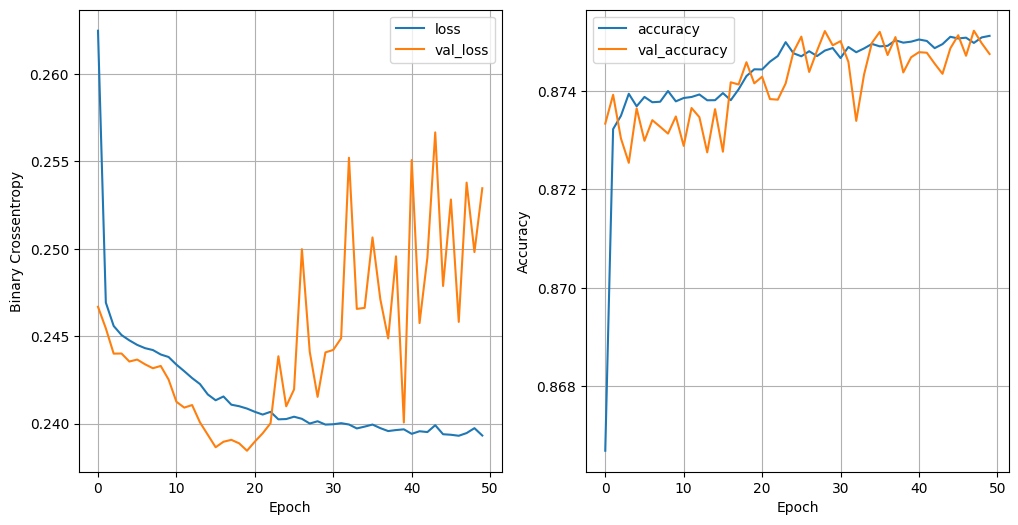

13271/13271 [==============================] - 12s 929us/step - loss: 0.2524 - accuracy: 0.8752


In [18]:
least_val_loss = float('inf')
least_loss_model = None
epochs = 50
least_val_loss = float('inf')
least_loss_model = None
epochs = 50
for nodes in [64]:
    for dropout_prob in [0]:
        for lr in [0.001]:
            for batch_size in [64]:
                print(f"{nodes} nodes, dropout_prob {dropout_prob}, lr {lr}, batch size {batch_size}")
                model, history = nn_train(X_train=X_train, y_train=y_train, X_valid=X_valid, y_valid=y_valid, epochs=epochs, nodes=nodes, dropout_prob=dropout_prob, lr=lr, batch_size=batch_size)
                plot_nn(history=history)
                val_loss = model.evaluate(X_test, y_test)[0]
                if val_loss < least_val_loss:
                    least_val_loss = val_loss
                    least_loss_model = model


In [2]:
least_val_loss

NameError: name 'least_val_loss' is not defined

In [1]:
data = [
    [16, 0, 0.1, 32, 73.90],
    [32, 0, 0.1, 32, 75.46],
    [64, 0, 0.1, 32, 74.21],
    
    [16, 0, 0.1, 32, 50.04],
    [32, 0, 0.1, 32, 49.96],
    [64, 0, 0.1, 32, 51.15],
    
    [(16, 32, 64), 0, 0.1, 128, (85.97, 82.77, 74.27)],
    [(16, 32, 64), 0, 0.005, 32, (87.57, 87.63, 87.61)],
    [(16, 32, 64), 0, 0.005, 64, (87.69, 87.68, 87.59)],
    [(16, 32, 64), 0, 0.005, 128, (87.68, 87.69, 87.75)],
    [(16, 32, 64), 0, 0.001, 32, (87.63, 87.53, 87.76)],
    [(16, 32, 64), 0, 0.001, 64, (87.65, 87.78, 87.79)],
    [(16, 32, 64), 0, 0.001, 128, (87.77, 87.65, 87.78)],
    [(16, 32, 64), 0.2, 0.1, 32, (73.62, 73.57, 73.88)],
    [(16, 32, 64), 0.2, 0.1, 64, (81.59, 73.57, 74.94)],
    [(16, 32, 64), 0.2, 0.1, 128, (82.85, 74.93, 74.27)],
    [(16, 32, 64), 0.2, 0.005, 32, (87.40, 87.35, 87.22)],
    [(16, 32, 64), 0.2, 0.005, 64, (87.03, 87.40, 87.59)],
    [(16, 32, 64), 0.2, 0.005, 128, (87.40, 87.49, 87.39)],
    [(16, 32, 64), 0.2, 0.001, 32, (87.10, 87.35, 87.38)],
    [(16, 32, 64), 0.2, 0.001, 64, (87.08, 87.37, 87.59)],
    [(16, 32, 64), 0.2, 0.001, 128, (87.20, 87.39, 87.52)]
]

df = pd.DataFrame(data, columns=['Nodes', 'Dropout Wahrscheinlichkeit', 'Lernrate', 'Batch Größe', 'Genauigkeit'])

# Display the DataFrame
print(df)

           Nodes  Dropout Wahrscheinlichkeit  Lernrate  Batch Größe  \
0             16                         0.0     0.100           32   
1             32                         0.0     0.100           32   
2             64                         0.0     0.100           32   
3             16                         0.0     0.100           32   
4             32                         0.0     0.100           32   
5             64                         0.0     0.100           32   
6   (16, 32, 64)                         0.0     0.100          128   
7   (16, 32, 64)                         0.0     0.005           32   
8   (16, 32, 64)                         0.0     0.005           64   
9   (16, 32, 64)                         0.0     0.005          128   
10  (16, 32, 64)                         0.0     0.001           32   
11  (16, 32, 64)                         0.0     0.001           64   
12  (16, 32, 64)                         0.0     0.001          128   
13  (1